<a href="https://colab.research.google.com/github/Vigneshthanga/Diabetic_Retinopathy/blob/master/tensorflow_bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Bayesian Convolutional Neural Network To Predict The Intensity Of Diabetic Retinopathy

##Team Members:

- Sivaranjani Kumar
- Vignesh Kumar Thangarajan
- Pooja Patil

##Introduction:

Diabetic Retinopathy is one of the major risks of losing vision among the people
who have diabetes. If found early, there is a higher chance of treating the disease otherwise it might cause irrecoverable blindness in people. A large dataset has been collected using the fundus photography . The class label specifies the severity of the DR on the scale 0-4 [No DR, Mild, Moderate, Severe, Proliferative DR]. Although we have many deep learning models to
identify the risk of DR from eye images, we do lack the uncertainty of prediction in those models. In other words, in connectionist models, the network uses point estimates as weights and it performs well with large datasets, but they fail to express uncertainty in regions with little or
no data. The proposed model will try to achieve the accuracy rate as high as the frequentist inference models. In addition to that, it handles uncertainty and avoiding overfitting to the data. 

Research has shown that it also eliminates the use of dropouts in the model. We know Bayesian 2 inference involves finding the integration over all parameters. This is now computationally intractable. The idea is to define a variational distribution q approximating the true posterior distribution of p. This can be seen as optimizing the KL divergence between p and q. But this also becomes computationally intractable. So, the research suggests applying “Bayes by
Backprop” in this step as the model sees the data. Now we got a tractable optimization function that uses Local Reparameterization Trick to find the parameters that minimize the variation difference between the function q and p.

![alt text](https://drive.google.com/uc?id=1DT1Z-_Ks4VGMysbksRLMUV6k6BXcTCZn)

###Each filter weight has a fixed value, as in the case of frequentist Convolutional Networks

![alt text](https://drive.google.com/uc?id=1Jx9ipXv5njf-wD7ZjfD49NjGuZuju8as)

###Each filter weight has a distribution, as in the case of Bayesian Convolutional Networks.

###Process:

The main contributions of our work are as follows:

1. We present how Bayes by Backprop can be efficiently applied to Cnns. We, therefore,introduce the idea of applying two convolutional operations, one for the mean and one for the variance.
2. We show how the model learns richer representations and predictions from cheap model averaging.
3. We empirically show that our proposed generic and reliable variational inference method for Bayesian Cnns can be applied to various Cnn architectures without any limitations on their performances.

###Mounting drive..

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


###Reading image data in H5 format from drive after applying Gaussina Blur on images

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['x_train', 'y_train']
x shape = (3662, 150528)
y shape = (3662,)


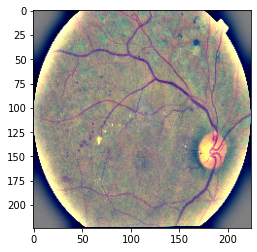

In [0]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
dest_file = '/content/gdrive/My Drive/eye_images/gaussian_color_224.h5'

with h5py.File(dest_file, "r") as f:
  print(list(f.keys()))
  x = f["x_train"][:]
  y = f["y_train"][:]
  print('x shape =', x.shape)
  print('y shape =', y.shape)

row = 5
image = x[row]
label = y[row]
image = (x[row]).reshape(224, 224, 3)
plt.imshow(image) 
plt.show()

###Reshaping the data..

In [0]:
import numpy as np
import pandas as pd
x= np.reshape(x,(3662,224,224,3))

###Splitting the dataset into train, test and validation data..

In [0]:
from sklearn.model_selection import train_test_split
x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.05, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=0.20, random_state=42)

In [0]:
x_train.shape[0]

2782

###Importing all necessary libraries...

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import warnings
import matplotlib
matplotlib.use('Agg')
from matplotlib import figure
from matplotlib.backends import backend_agg
import numpy as np
import tensorflow_probability as tfp
import tensorflow as tf

warnings.simplefilter(action='ignore')

###Initializing parameters for our bayesian model..

In [0]:
try:
  import seaborn as sns  # pylint: disable=g-import-not-at-top
  HAS_SEABORN = True
except ImportError:
  HAS_SEABORN = False

tfd = tfp.distributions

IMAGE_SHAPE = [224, 224, 3]
NUM_TRAIN_EXAMPLES = x_train.shape[0]
NUM_HELDOUT_EXAMPLES = x_valid.shape[0]
NUM_CLASSES = 5

learning_rate = 0.001
num_epochs = 10
batch_size = 32
data_dir = '/content/gdrive/My Drive/bayesian_eye/'
model_dir = '/content/gdrive/My Drive/bayesian_eye/model_v1'
viz_steps = 10
fake_data = False
num_monte_carlo = 50

### Defining utility functions to plot weight posteriors and heldout predictions

In [0]:
def plot_weight_posteriors(names, qm_vals, qs_vals, fname):
  fig = figure.Figure(figsize=(6, 3))
  canvas = backend_agg.FigureCanvasAgg(fig)

  ax = fig.add_subplot(1, 2, 1)
  for n, qm in zip(names, qm_vals):
    sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
  ax.set_title('weight means')
  ax.set_xlim([-1.5, 1.5])
  ax.legend()

  ax = fig.add_subplot(1, 2, 2)
  for n, qs in zip(names, qs_vals):
    sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
  ax.set_title('weight stddevs')
  ax.set_xlim([0, 1.])

  fig.tight_layout()
  canvas.print_figure(fname, format='png')
  print('saved {}'.format(fname))


def plot_heldout_prediction(input_vals, probs,
                            fname, n=10, title=''):
  fig = figure.Figure(figsize=(9, 3*n))
  canvas = backend_agg.FigureCanvasAgg(fig)
  for i in range(n):
    ax = fig.add_subplot(n, 3, 3*i + 1)
    ax.imshow(input_vals[i, :], interpolation='None')

    ax = fig.add_subplot(n, 3, 3*i + 2)
    for prob_sample in probs:
      sns.barplot(np.arange(5), prob_sample[i, :], alpha=0.1, ax=ax)
      ax.set_ylim([0, 1])
    ax.set_title('posterior samples')

    ax = fig.add_subplot(n, 3, 3*i + 3)
    sns.barplot(np.arange(5), tf.reduce_mean(probs[:, i, :], axis=0), ax=ax)
    ax.set_ylim([0, 1])
    ax.set_title('predictive probs')
  fig.suptitle(title)
  fig.tight_layout()

  canvas.print_figure(fname, format='png')
  print('saved {}'.format(fname))

In [0]:
from tensorflow.keras.layers import *

## Model Definintion for Bayesian Neural Network


1.   KL Divergence function is used to find the difference between two probability distribution
2.   Convolution2DFlipout  - This layer creates a convolution kernel that is convolved (actually cross-correlated) with the layer input to produce a tensor of outputs. It may also include a bias addition and activation function on the outputs. It assumes the kernel and/or bias are drawn from distributions.
3. MaxPooling2D - Downsamples the input representation by taking the maximum value over the window defined by pool_size for each dimension along the features axis.
4. Dense Flipout - This layer implements the Bayesian variational inference analogue to a dense layer by assuming the kernel and/or the bias are drawn from distributions. 

Optimizer(Adam) - Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.The algorithms leverages the power of adaptive learning rates methods to find individual learning rates for each parameter.

Loss(Categorical Crossentropy) - This crossentropy loss function is used when there are two or more label classes. We expect labels to be provided in a one_hot representation. 

Metrics(Accuracy) - This metric creates two local variables, total and count that are used to compute the frequency with which y_pred matches y_true. This frequency is ultimately returned as binary accuracy: an idempotent operation that simply divides total by count.




In [0]:
def create_model():
  
  # KL divergence weighted by the number of training samples, using
  # lambda function to pass as input to the kernel_divergence_fn on
  # flipout layers.

  kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /
                            tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

  model = tf.keras.models.Sequential(
      [
      tfp.layers.Convolution2DFlipout(
          32, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tfp.layers.Convolution2DFlipout(
          64, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tfp.layers.Convolution2DFlipout(
          128, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.Flatten(),
      tfp.layers.DenseFlipout(
          300, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tfp.layers.DenseFlipout(
          100, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tfp.layers.DenseFlipout(
          NUM_CLASSES, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.softmax)
  ]
  )
  optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

  # We use the categorical_crossentropy loss since the Eye dataset contains
  # five labels. The Keras API will then automatically add the
  # Kullback-Leibler divergence (contained on the individual layers of
  # the model), to the cross entropy loss, effectively
  # calcuating the (negated) Evidence Lower Bound Loss (ELBO)

  model.compile(optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'], experimental_run_tf_function=False)
  return model


## Generate Sequence of Eye images..

In [0]:
class EyeSequence(tf.keras.utils.Sequence):
  def __init__(self, data=None, batch_size=32, fake_data_size=None):
    if data:
      images, labels = data
    else:
      images, labels = EyeSequence.__generate_fake_data(
          num_images=fake_data_size, num_classes=NUM_CLASSES)
    self.images, self.labels = EyeSequence.__preprocessing(
        images, labels)
    self.batch_size = batch_size

  @staticmethod
  def __generate_fake_data(num_images, num_classes):
    images = np.random.randint(low=0, high=256,
                               size=(num_images, IMAGE_SHAPE[0],
                                     IMAGE_SHAPE[1]))
    labels = np.random.randint(low=0, high=num_classes,
                               size=num_images)
    return images, labels

  @staticmethod
  def __preprocessing(images, labels):
    labels = tf.keras.utils.to_categorical(labels)
    return images, labels

  def __len__(self):
    return int(tf.math.ceil(len(self.images) / self.batch_size))

  def __getitem__(self, idx):
    batch_x = self.images[idx * self.batch_size: (idx + 1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
    return batch_x, batch_y

In [0]:
from tensorflow.keras.models import *

In [0]:
x_train.shape

(2782, 224, 224, 3)

## Model Training

In [0]:
import sys
train_set = (x_train, y_train)
heldout_set = (x_valid, y_valid)
train_seq = EyeSequence(data=train_set, batch_size=batch_size)
heldout_seq = EyeSequence(data=heldout_set, batch_size=batch_size)

model = create_model()
model.build(input_shape=[None, 224, 224, 3])

print(' ... Training convolutional neural network')
prev_epoch = -1
for epoch in range(num_epochs):
  epoch_accuracy, epoch_loss = [], []
  for step, (batch_x, batch_y) in enumerate(train_seq):
    batch_loss, batch_accuracy = model.train_on_batch(
          batch_x, batch_y)
    epoch_accuracy.append(batch_accuracy)
    epoch_loss.append(batch_loss)

    if step % 10 == 0:
      print('Epoch: {}, Batch index: {}, '
            'Loss: {:.3f}, Accuracy: {:.3f}'.format(
                epoch, step,
                tf.reduce_mean(epoch_loss),
                tf.reduce_mean(epoch_accuracy)))

    if prev_epoch != epoch:
      prev_epoch = epoch
      # Compute log prob of heldout set by averaging draws from the model:
      # p(heldout | train) = int_model p(heldout|model) p(model|train)
      #                   ~= 1/n * sum_{i=1}^n p(heldout | model_i)
      # where model_i is a draw from the posterior p(model|train).
      print(' ... Running monte carlo inference')
      probs = tf.stack([model.predict(heldout_seq, verbose=1)
                          for _ in range(num_monte_carlo)], axis=0)
      mean_probs = tf.reduce_mean(probs, axis=0)
      heldout_log_prob = tf.reduce_mean(tf.math.log(mean_probs))
      print(' ... Held-out nats: {:.3f}'.format(heldout_log_prob))

      if HAS_SEABORN:
        names = [layer.name for layer in model.layers
                   if 'flipout' in layer.name]
        qm_vals = [layer.kernel_posterior.mean()
                     for layer in model.layers
                     if 'flipout' in layer.name]
        qs_vals = [layer.kernel_posterior.stddev()
                     for layer in model.layers
                     if 'flipout' in layer.name]
        plot_weight_posteriors(names, qm_vals, qs_vals,
                                 fname=os.path.join(
                                     model_dir,
                                     'epoch{}_step{:05d}_weights.png'.format(
                                         epoch, step)))
        plot_heldout_prediction(heldout_seq.images, probs,
                                  fname=os.path.join(
                                      model_dir,
                                      'epoch{}_step{}_pred.png'.format(
                                          epoch, step)),
                                  title='mean heldout logprob {:.2f}'
                                  .format(heldout_log_prob))

Instructions for updating:
Please use `layer.add_weight` method instead.
 ... Training convolutional neural network
Epoch: 0, Batch index: 0, Loss: 109968.148, Accuracy: 0.156
 ... Running monte carlo inference
22/22 [==============================] - 1s 39ms/step
 ... Held-out nats: -inf
saved /content/gdrive/My Drive/bayesian_eye/model_v1/epoch0_step00000_weights.png
saved /content/gdrive/My Drive/bayesian_eye/model_v1/epoch0_step0_pred.png
Epoch: 0, Batch index: 10, Loss: 109781.758, Accuracy: 0.318
Epoch: 0, Batch index: 20, Loss: 109473.211, Accuracy: 0.399
Epoch: 0, Batch index: 30, Loss: 109252.156, Accuracy: 0.440
Epoch: 0, Batch index: 40, Loss: 109053.695, Accuracy: 0.466
Epoch: 0, Batch index: 50, Loss: 108863.273, Accuracy: 0.479
Epoch: 0, Batch index: 60, Loss: 108676.000, Accuracy: 0.490
Epoch: 0, Batch index: 70, Loss: 108489.867, Accuracy: 0.504
Epoch: 0, Batch index: 80, Loss: 108303.984, Accuracy: 0.509
Epoch: 1, Batch index: 0, Loss: 106554.430, Accuracy: 0.719
 ... 

## Model Summary

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou multiple                  4832      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip multiple                  102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip multiple                  409728    
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense_flipout (DenseFlipout) multiple                  2

## Saving the model in Protocol Buffer format

In [0]:
model.save('/content/gdrive/My Drive/bayesian_model_v1/model_v1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/bayesian_model_v1/model_v1/assets


## Saving the model in H5 format

In [0]:
model.save('/content/gdrive/My Drive/bayesian_h5/bayesian_model.h5')

In [0]:
import h5py

In [0]:
file = h5py.File('/content/gdrive/My Drive/bayesian_h5/bayesianmodel.h5', 'w')
weight = model.get_weights()
for i in range(len(weight)):
   file.create_dataset('weight' + str(i), data=weight[i])
file.close()

In [0]:
!ls /content/gdrive/My\ Drive/bayesian_h5

bayesian_model.h5


In [0]:
load_model = tf.keras.models.load_model('/content/gdrive/My Drive/bayesian_model_v1/model_v1')

## Loading Model Summary

In [0]:
load_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_3 (Conv2DFlip multiple                  4832      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_flipout_4 (Conv2DFlip multiple                  102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_flipout_5 (Conv2DFlip multiple                  409728    
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_flipout_3 (DenseFlipou multiple                 

## Saving the Model to JSON

In [0]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/model.json", "w") as json_file:
  json_file.write(model_json)

## Testing an image using the loaded model

In [0]:
test_img = x_valid[3]

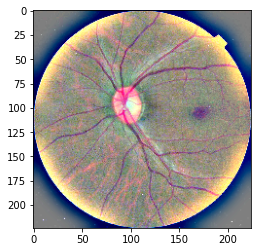

In [0]:
plt.imshow(x_valid[3])

In [0]:
y_valid[3]

0

In [0]:
test_img = test_img.reshape(1,224,224,3)

In [0]:
test_img.shape

(1, 224, 224, 3)

In [0]:
p = load_model.predict(test_img, verbose=1)

1/1 [==============================] - 0s 1ms/step


## Predicitive Proabablities of this test image

In [0]:
p

array([[9.7448879e-01, 4.9230871e-03, 1.9107787e-02, 1.1619476e-03,
        3.1847204e-04]], dtype=float32)

In [0]:
import numpy as np

## Retinopathy Classification for test image

In [0]:
np.argmax(p)

0